# Project Loan Default Prediction

# Instituto Politécnico de Coimbra
## Instituto Superior de Engenharia de Coimbra
## Mestrado em Engenharia Informática - Análise Inteligente de Dados
## Machine Learning
### Authors: 
- Gonçalo Marouvo Santos nº 2022104002, [https://www.linkedin.com/in/goncalomarouvo/](https://www.linkedin.com/in/goncalomarouvo/)
- Diogo Cid nº 2022103099, [https://www.linkedin.com/in/diogocid/](https://www.linkedin.com/in/diogocid/)

#### Coimbra, November 2022
#### The orginal data set can be found here: [https://www.kaggle.com/datasets/marcbuji/loan-default-prediction]

In [557]:
#All Libraries used
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#skitlearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#depois verificar se usámos tudo


In [558]:
#Import Dataset
df = pd.read_csv('loan_default_prediction.csv')
#print(df.columns)
df.head()

,ID,Asst_Reg,GGGrade,Experience,Validation,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Designation,...,File_Status,State,Account_Open,Total_Unpaid_CL,Duration,Unpaid_Amount,Reason,Claim_Type,Due_Fee,Default
0,95074,421802,II,>10yrs,Vfied,633600.00,MORTGAGE,0,0,GLENDALE NISSAN,...,fully paid,California,17,58598.0,3 years,31216.05,debt consolidation,I,0.0,0
1,134131,3964312,IV,7yrs,Source Verified,85483.20,RENT,0,0,Business Teacher,...,whole,NC,15,18924.0,5 years,11660.49,debt consolidation,I,0.0,0
2,92602,4247560,III,<1yr,Source Verified,79200.00,RENT,0,0,driver,...,whole,Florida,7,15604.0,5 years,5637.87,major purchase,I,0.0,0
3,22591,197179,III,<1yr,Vfied,61600.00,RENT,0,0,AvePoint,...,fully paid,NewJersey,9,22410.0,3 years,15607.17,major purchase,I,0.0,1
4,125060,4646684,V,2yrs,Source Verified,68053.92,RENT,0,0,Lead Tester,...,fully paid,LA,10,36022.0,5 years,27472.86,debt consolidation,I,0.0,0


## Limpeza de features do dataset

In [559]:
#remover variáveis que a priori não fazem sentido; ver relatorio para justificações
df=df.drop(['ID','Validation','Designation','Debt_to_Income','Postal_Code','Deprecatory_Records',\
            'Inquiries','Gross_Collection','Sub_GGGrade','Total_Unpaid_CL','File_Status'],axis=1)
print(df.columns)

Index(['Asst_Reg', 'GGGrade', 'Experience', 'Yearly_Income', 'Home_Status',
       'Unpaid_2_years', 'Already_Defaulted', 'Lend_Amount',
       'Interest_Charged', 'Usage_Rate', 'Present_Balance', 'State',
       'Account_Open', 'Duration', 'Unpaid_Amount', 'Reason', 'Claim_Type',
       'Due_Fee', 'Default'],
      dtype='object')


In [560]:
#VER SE VARIAVEL NUMERICA TEM ALGUM STRING
df['Default'].value_counts()/df.shape[0] #quantos defaults temos
#print(df[df['Default']==1]['Default'].value_counts())

0    0.811291
1    0.188709
Name: Default, dtype: float64

## Conversão de variáveis

In [561]:
def romanToInt(i):
    roman = {'I':1,'V':5,'X':10,'L':50,'C':100,'D':500,'M':1000,'IV':4,'IX':9,'XL':40,'XC':90,'CD':400,'CM':900}
    j = 0
    num = 0
    while j < len(i):
        if j+1<len(i) and i[j:j+2] in roman:
            num+=roman[i[j:j+2]]
            j+=2
        else:

            num+=roman[i[j]]
            j+=1
    return num
#adicionar verificação para não estoirar ao correr a 2ª vez
#Conversão dos anos de experiência para numérico
df['Experience']=df['Experience'].apply(lambda i: 10 if i[0:1]=='>' else 1 if i[0:1]=='<' else int(i[0:1]))
#Conversão da duração para numérico
df['Duration']=df['Duration'].apply(lambda i : i.replace(' years','')).astype(int)
#Conversão da GGGrade valor ordinal para numérico
df['GGGrade']=df['GGGrade'].apply(romanToInt).astype(int)
#ver resultado
df.head()

,Asst_Reg,GGGrade,Experience,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,State,Account_Open,Duration,Unpaid_Amount,Reason,Claim_Type,Due_Fee,Default
0,421802,2,10,633600.00,MORTGAGE,0,0,42023.25,15.39,88.924,607161.90,California,17,3,31216.05,debt consolidation,I,0.0,0
1,3964312,4,7,85483.20,RENT,0,0,38133.00,9.94,102.856,269234.06,NC,15,5,11660.49,debt consolidation,I,0.0,0
2,4247560,3,1,79200.00,RENT,0,0,17100.00,22.35,60.372,22476.53,Florida,7,5,5637.87,major purchase,I,0.0,0
3,197179,3,1,61600.00,RENT,0,0,5130.00,10.36,116.272,15242.09,NewJersey,9,3,15607.17,major purchase,I,0.0,1
4,4646684,5,2,68053.92,RENT,0,0,19665.00,13.68,127.280,65433.94,LA,10,5,27472.86,debt consolidation,I,0.0,0


In [562]:
#ver dimensão atual da base
df.shape

(87500, 19)

## Verificação do conteúdo das features

In [563]:
#verificar se todos os elementos de uma feature são do mesmo tipo
#quando uma feature tem varios tipos, df.ddtype atribui "object" como tipo
for i in df.columns:    
    dftype=df[i].apply(type)
    print(dftype.value_counts())

<class 'int'>    87500
Name: Asst_Reg, dtype: int64
<class 'int'>    87500
Name: GGGrade, dtype: int64
<class 'int'>    87500
Name: Experience, dtype: int64
<class 'float'>    87500
Name: Yearly_Income, dtype: int64
<class 'str'>    87500
Name: Home_Status, dtype: int64
<class 'int'>    87500
Name: Unpaid_2_years, dtype: int64
<class 'int'>    87500
Name: Already_Defaulted, dtype: int64
<class 'float'>    87500
Name: Lend_Amount, dtype: int64
<class 'float'>    87500
Name: Interest_Charged, dtype: int64
<class 'float'>    87500
Name: Usage_Rate, dtype: int64
<class 'float'>    87500
Name: Present_Balance, dtype: int64
<class 'str'>    87500
Name: State, dtype: int64
<class 'int'>    87500
Name: Account_Open, dtype: int64
<class 'int'>    87500
Name: Duration, dtype: int64
<class 'float'>    87500
Name: Unpaid_Amount, dtype: int64
<class 'str'>    87500
Name: Reason, dtype: int64
<class 'str'>    87500
Name: Claim_Type, dtype: int64
<class 'float'>    87500
Name: Due_Fee, dtype: int64
<

## Remoção de null e vazio

In [564]:
#ver elementos nulos do dataset em %
display(df.isnull().sum()/df.shape[0])
#info
df.info()

Asst_Reg             0.000000
GGGrade              0.000000
Experience           0.000000
Yearly_Income        0.063714
Home_Status          0.000000
Unpaid_2_years       0.000000
Already_Defaulted    0.000000
Lend_Amount          0.000000
Interest_Charged     0.000000
Usage_Rate           0.000000
Present_Balance      0.000000
State                0.000000
Account_Open         0.000000
Duration             0.000000
Unpaid_Amount        0.055451
Reason               0.000000
Claim_Type           0.000000
Due_Fee              0.000000
Default              0.000000
dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87500 entries, 0 to 87499
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Asst_Reg           87500 non-null  int64  
 1   GGGrade            87500 non-null  int32  
 2   Experience         87500 non-null  int64  
 3   Yearly_Income      81925 non-null  float64
 4   Home_Status        87500 non-null  object 
 5   Unpaid_2_years     87500 non-null  int64  
 6   Already_Defaulted  87500 non-null  int64  
 7   Lend_Amount        87500 non-null  float64
 8   Interest_Charged   87500 non-null  float64
 9   Usage_Rate         87500 non-null  float64
 10  Present_Balance    87500 non-null  float64
 11  State              87500 non-null  object 
 12  Account_Open       87500 non-null  int64  
 13  Duration           87500 non-null  int32  
 14  Unpaid_Amount      82648 non-null  float64
 15  Reason             87500 non-null  object 
 16  Claim_Type         875

In [565]:
#eliminar observações com pelo menos uma feature sem valores
df=df.dropna()
df.isnull().sum()
display(df.shape)
#drop duplicates
df.drop_duplicates()
df.shape

(77376, 19)

(77376, 19)

## Análise com variáveis numéricas continuas

In [566]:
#DATA FRAME COM VARIÁVEIS NUMERICAS CONTINUAS
vnumcont=['Asst_Reg','Experience','Yearly_Income','Lend_Amount','Interest_Charged','Usage_Rate','Present_Balance',\
            'Due_Fee','Unpaid_Amount']
#criar copia para não "estragar" dados originais
numcont=df[vnumcont].copy()
numcont.head()

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,Due_Fee,Unpaid_Amount
0,421802,10,633600.00,42023.25,15.39,88.924,607161.90,0.0,31216.05
1,3964312,7,85483.20,38133.00,9.94,102.856,269234.06,0.0,11660.49
2,4247560,1,79200.00,17100.00,22.35,60.372,22476.53,0.0,5637.87
3,197179,1,61600.00,5130.00,10.36,116.272,15242.09,0.0,15607.17
4,4646684,2,68053.92,19665.00,13.68,127.280,65433.94,0.0,27472.86


### Análise das estatísticas descritiva

In [567]:
#análise das estatísticas descritivas
#médias, desvios padrão, max, min percentis...
numcont.describe()

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,Due_Fee,Unpaid_Amount
count,7.737600e+04,77376.000000,7.737600e+04,77376.000000,77376.000000,77376.000000,7.737600e+04,77376.000000,7.737600e+04
mean,3.801793e+06,6.144360,1.349915e+05,25927.213109,16.518339,95.489869,2.363786e+05,0.317507,2.953228e+04
std,2.289120e+06,3.538256,9.953162e+04,14443.738100,4.905345,40.610291,2.553444e+05,3.556516,3.757589e+04
min,2.484700e+04,1.000000,8.800000e+03,1710.000000,8.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,1.486830e+06,3.000000,8.330256e+04,15048.000000,12.310000,66.048000,5.181092e+04,0.000000,1.144332e+04
50%,4.133126e+06,7.000000,1.144000e+05,23940.000000,16.490000,97.008000,1.386309e+05,0.000000,2.088594e+04
75%,5.956216e+06,10.000000,1.601600e+05,34200.000000,20.772500,126.592000,3.535544e+05,0.000000,3.643497e+04
max,7.351847e+06,10.000000,8.264031e+06,59850.000000,25.000000,1534.756000,5.629234e+06,169.050000,1.338778e+06


### Histogramas

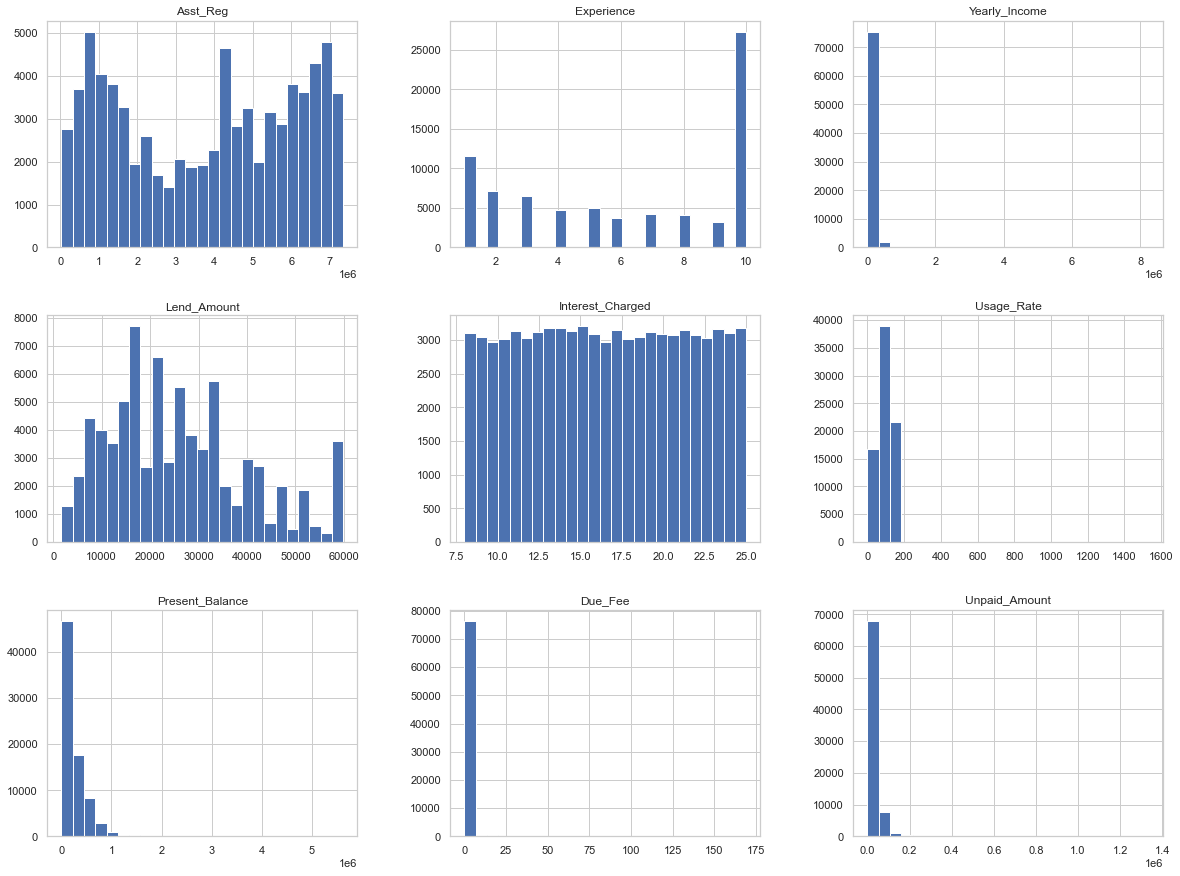

In [568]:
#plots
numcont.hist(bins=25,figsize=(20,15))
plt.show()

### Gráficos Boxplot

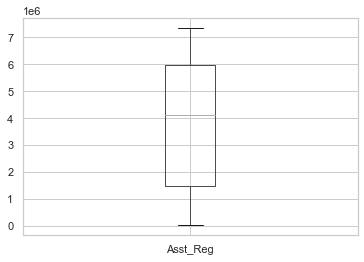

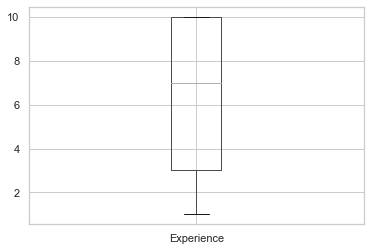

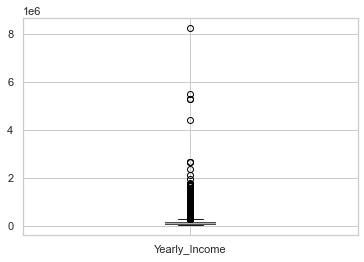

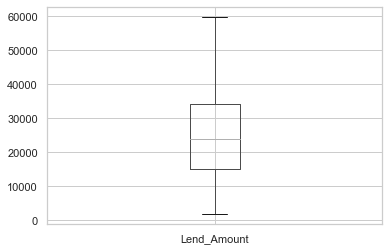

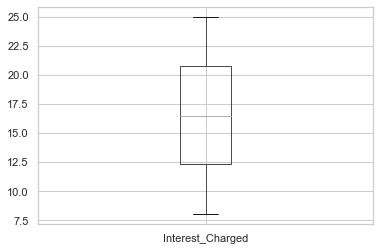

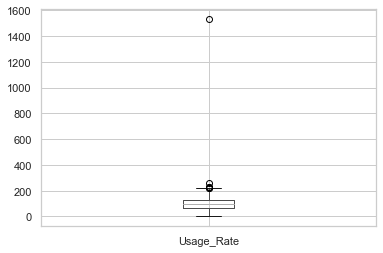

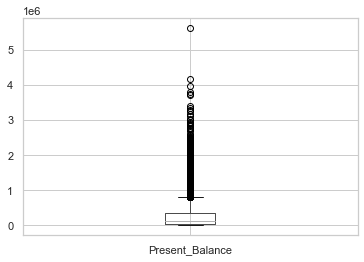

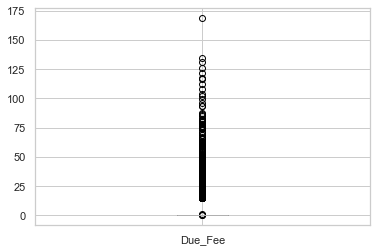

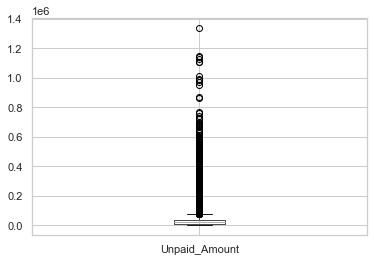

In [569]:
for i in numcont.columns:
    plt.figure()
    df.boxplot(column = i)
#fazer scroll na imagem, gerou todos os boxplots!

### Gráficos violin - compraração de variáveis continuas label

,Asst_Reg,GGGrade,Experience,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,State,Account_Open,Duration,Unpaid_Amount,Reason,Claim_Type,Due_Fee,Default
0,421802,2,10,633600.00,MORTGAGE,0,0,42023.25,15.39,88.924,607161.90,California,17,3,31216.05,debt consolidation,I,0.0,0
1,3964312,4,7,85483.20,RENT,0,0,38133.00,9.94,102.856,269234.06,NC,15,5,11660.49,debt consolidation,I,0.0,0
2,4247560,3,1,79200.00,RENT,0,0,17100.00,22.35,60.372,22476.53,Florida,7,5,5637.87,major purchase,I,0.0,0
3,197179,3,1,61600.00,RENT,0,0,5130.00,10.36,116.272,15242.09,NewJersey,9,3,15607.17,major purchase,I,0.0,1
4,4646684,5,2,68053.92,RENT,0,0,19665.00,13.68,127.280,65433.94,LA,10,5,27472.86,debt consolidation,I,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87494,5409793,3,1,246400.00,RENT,0,0,20520.00,12.62,87.720,350087.11,Newyork,16,3,10383.12,small business,I,0.0,0
87495,4535984,2,10,75680.00,RENT,0,0,10260.00,8.35,51.084,15100.14,MI,12,3,10012.05,debt consolidation,I,0.0,0
87496,2624710,4,3,90423.52,RENT,0,0,27360.00,24.18,129.172,102811.88,MA,23,5,24921.54,debt consolidation,I,0.0,0
87497,5966919,2,10,91520.00,MORTGAGE,0,0,8550.00,11.03,83.420,14584.11,CT,8,3,14517.90,debt consolidation,I,0.0,0


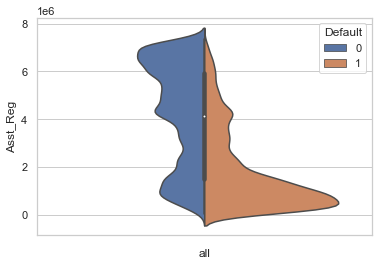

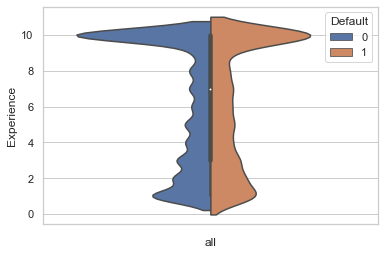

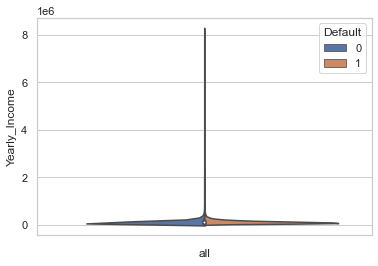

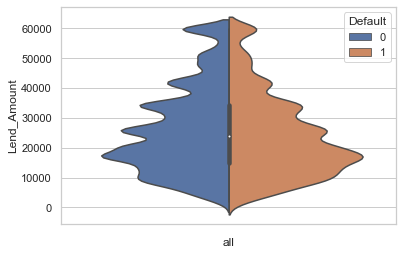

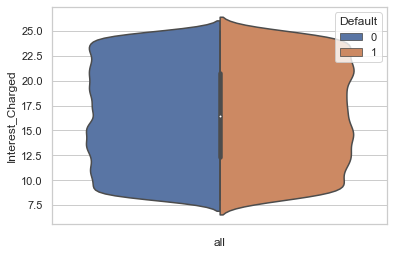

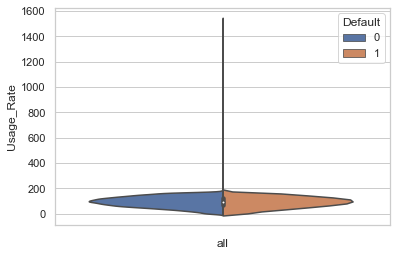

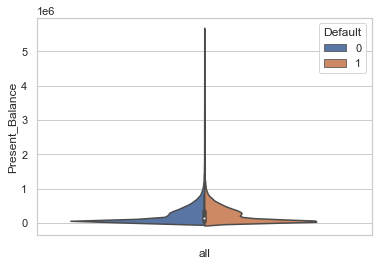

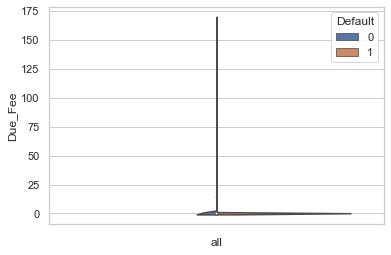

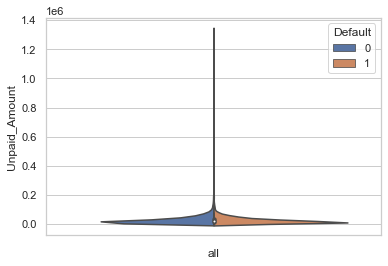

In [570]:
#gráfico obriga a que se dê um x, por isso criou-se uma feature que é um conjunto vazio
#esta é uma feature que depois é apagada
#nesta parte, já tentamos relacionar as variáveis continuas com o nosso label
#vamos comparar a distaibuição para defalt=0 vs default=1
#exemplo para total assets: as pessoas que incumprem tendencialmente têm menos assets
#como se vê no gráfico? parte laranja (incumprimentos) está mais concentrada perto do zero, vs parte azul
df['all']=""
sns.set(style="whitegrid")
for i in vnumcont:
    plt.figure()
    sns.violinplot(data=df,y=i,x='all',hue='Default',split=True)#, palette="Set2", dodge=True)
    
df.drop('all',axis=1)

#### Abordagem a outlier

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,Due_Fee,Unpaid_Amount,Default
0,421802.0,10,220000.00,42023.25,15.39,88.924,564636.185,0.0,31216.05,0
1,3964312.0,7,85483.20,38133.00,9.94,102.856,269234.060,0.0,11660.49,0
2,4247560.0,1,79200.00,17100.00,22.35,60.372,22476.530,0.0,5637.87,0
3,197179.0,1,61600.00,5130.00,10.36,116.272,15242.090,0.0,15607.17,1
4,4646684.0,2,68053.92,19665.00,13.68,127.280,65433.940,0.0,27472.86,0
...,...,...,...,...,...,...,...,...,...,...
87494,5409793.0,1,220000.00,20520.00,12.62,87.720,350087.110,0.0,10383.12,0
87495,4535984.0,10,75680.00,10260.00,8.35,51.084,15100.140,0.0,10012.05,0
87496,2624710.0,3,90423.52,27360.00,23.32,129.172,102811.880,0.0,24921.54,0
87497,5966919.0,10,91520.00,8550.00,11.03,83.420,14584.110,0.0,14517.90,0


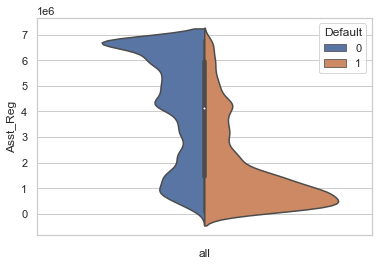

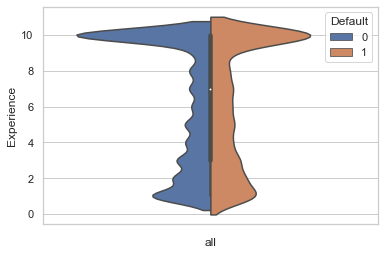

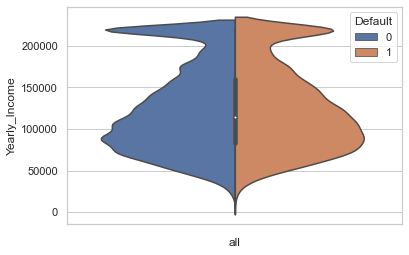

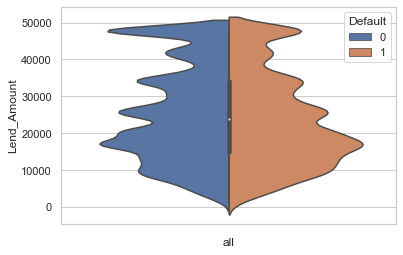

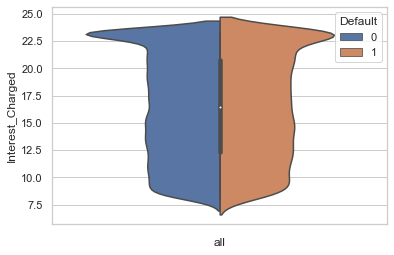

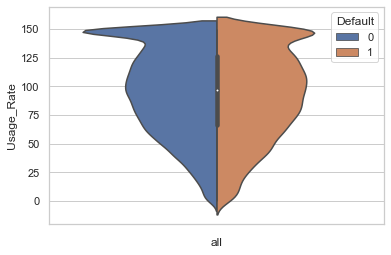

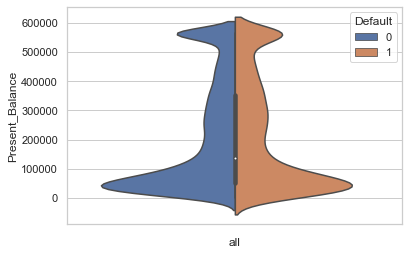

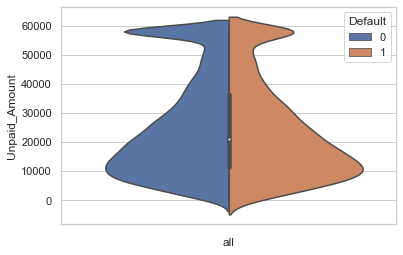

In [571]:
#acima não dá para ver bem nas features que têm outlier
#fazemos um tecto máximo nos valores dos outliers, para melhor análise (função .clip())
#tecto é valor do quantil 90%
#tirar o due_fee porque quantil 90% é 0: fica uma coluna de zeros!
import warnings
warnings.filterwarnings('ignore')

vnumcont_trunc=vnumcont+['Default']
numcont_trunc=df[vnumcont_trunc]

numcont_trunc['all']=""
sns.set(style="whitegrid")
for i in vnumcont:
    if i!='Due_Fee':
        up=numcont[i].quantile(0.9)
        numcont_trunc[i]=numcont_trunc[i].clip(upper=up)
        plt.figure()
        sns.violinplot(data=numcont_trunc,y=i,x='all',hue='Default',split=True)#, palette="Set2", dodge=True)
    
numcont_trunc.drop('all',axis=1)

#### Gráfico violin - distribuição entre assets

<AxesSubplot:xlabel='GGGrade', ylabel='Asst_Reg'>

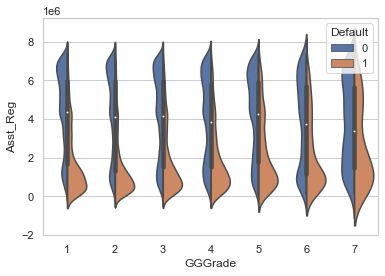

In [572]:
sns.set(style="whitegrid")
sns.violinplot(data=df,y='Asst_Reg',x='GGGrade',hue='Default',split=True)#, palette="Set2", dodge=True)

<AxesSubplot:xlabel='Home_Status', ylabel='Asst_Reg'>

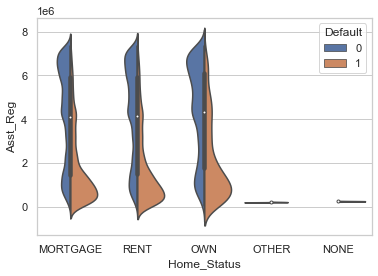

In [573]:
sns.set(style="whitegrid")
sns.violinplot(data=df,y='Asst_Reg',x='Home_Status',hue='Default',split=True)#, palette="Set2", dodge=True)

### Gráficos Radar

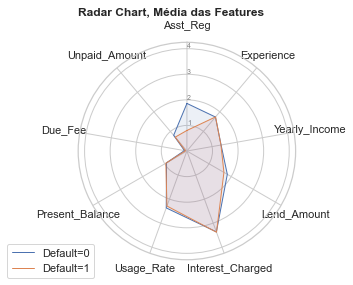

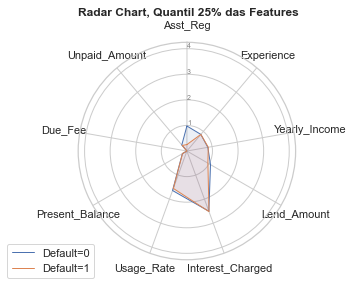

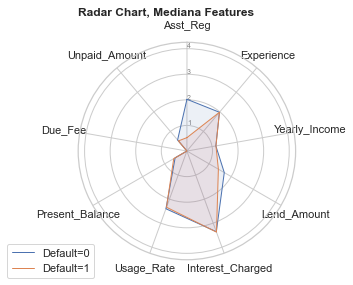

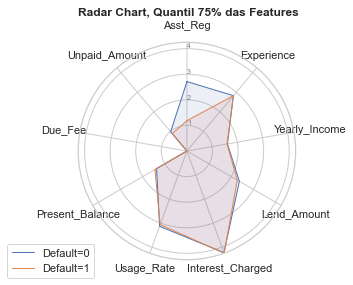

In [574]:
#RADAR CHART
#ver como uma estatistica das features numéricas contínuas (média, quantis) varia para os 2 grupos da label
#Dividimos pelo desvio padrão para ter a mesma escala: todas as diferenças de entre os 2 grupos são
#em unidades de desvio padrão
#comparar relação quando default=0 vs =1 para média, quantil 0.25, median e quantil 0.5
def spider(ncradar,nome):
    categories=list(ncradar)
    N = len(categories)# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * 3.14 for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    plt.figure()
    ax = plt.subplot(111, polar=True)
    # If you want the first axis to be on top:
    ax.set_theta_offset(3.14 / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([1,2,3,4], ["1","2","3","4"], color="grey", size=7)
    plt.ylim(0,4.25)
    # ------- PART 2: Add plots
    # Name1
    values=ncradar.loc[0].values.flatten().tolist()
    values += values[:1]
    #display(angles)
    #display(values)
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Default=0")
    ax.fill(angles, values, 'b', alpha=0.1)
    # Name2
    values=ncradar.loc[1].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Default=1")
    ax.fill(angles, values, 'r', alpha=0.1)
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title(nome,loc='left',  x=0, y=1.1,fontweight="bold")

ncradar=(df[vnumcont].groupby(df['Default']).mean()/df[vnumcont].std())
ncradarq1=(df[vnumcont].groupby(df['Default']).quantile(0.25)/df[vnumcont].std())
ncradarq2=(df[vnumcont].groupby(df['Default']).quantile(0.5)/df[vnumcont].std())
ncradarq3=(df[vnumcont].groupby(df['Default']).quantile(0.75)/df[vnumcont].std())
spider(ncradar,'Radar Chart, Média das Features')
spider(ncradarq1,'Radar Chart, Quantil 25% das Features')
spider(ncradarq2,'Radar Chart, Mediana Features')
spider(ncradarq3,'Radar Chart, Quantil 75% das Features')

## Análise com variáveis numéricas discretas

In [575]:
##DATA FRAME COM VARIÁVEIS NUMERICAS DISCRETAS
#criar dataframe de variaveis numericas discretas
vnumdisc=['Unpaid_2_years','Already_Defaulted','Account_Open','Duration']
numdisc=df[vnumdisc].copy()
numdisc.head()

,Unpaid_2_years,Already_Defaulted,Account_Open,Duration
0,0,0,17,3
1,0,0,15,5
2,0,0,7,5
3,0,0,9,3
4,0,0,10,5


### Análise das estatísticas descritiva

In [576]:
numdisc.describe()

,Unpaid_2_years,Already_Defaulted,Account_Open,Duration
count,77376.000000,77376.000000,77376.000000,77376.000000
mean,0.331873,0.005609,12.781961,3.627197
std,0.875049,0.083197,5.381400,0.927917
min,0.000000,0.000000,2.000000,3.000000
25%,0.000000,0.000000,9.000000,3.000000
50%,0.000000,0.000000,12.000000,3.000000
75%,0.000000,0.000000,16.000000,5.000000
max,18.000000,6.000000,83.000000,5.000000


### Histogramas

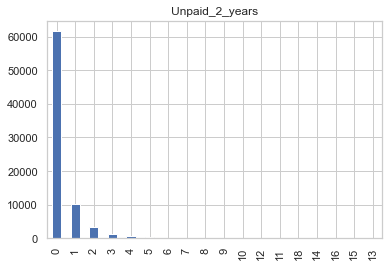

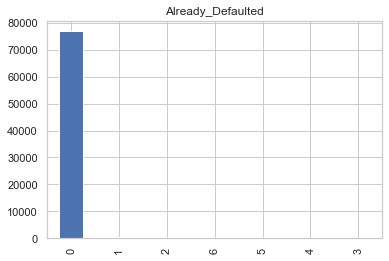

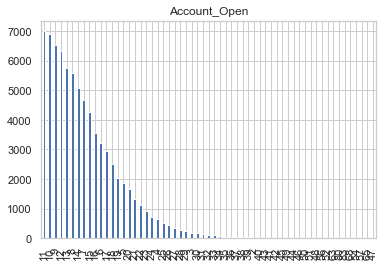

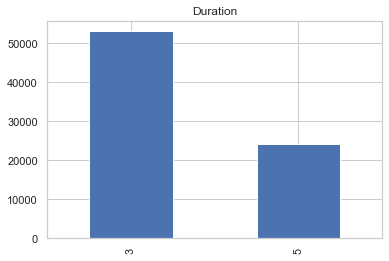

In [577]:
#histograma de tudo o que está em numdisc
for i in numdisc.columns:
    plt.figure()
    numdisc[i].value_counts().plot(kind='bar',title=i)

## Análise com variáveis categóricas e ordinais

In [519]:
#DATA FRAME COM VARIÁVEIS CATEGORICAS + ORDINAL
#dataframe features categoricas
vcatord=['Home_Status','State','Reason','Claim_Type','GGGrade']
catord=df[vcat].copy()
catord.head()

,Home_Status,State,Reason,Claim_Type
0,MORTGAGE,California,debt consolidation,I
1,RENT,NC,debt consolidation,I
2,RENT,Florida,major purchase,I
3,RENT,NewJersey,major purchase,I
4,RENT,LA,debt consolidation,I


### Análise das estatísticas descritivas

In [463]:
catord.describe()

,Home_Status,State,Reason,Claim_Type
count,77376,77376,77376,77376
unique,5,49,13,2
top,MORTGAGE,California,debt consolidation,I
freq,39077,11194,46471,77337


### Histogramas

MORTGAGE    39077
RENT        30853
OWN          7436
OTHER           6
NONE            4
Name: Home_Status, dtype: int64
California    11194
Newyork        6414
TX             6307
Florida        5149
IL             3091
NewJersey      2877
PA             2797
Ohio           2602
GA             2572
VA             2251
NC             2230
MI             1995
Maryland       1857
AZ             1797
MA             1764
CO             1685
WA             1627
MN             1493
IN             1276
MO             1253
TN             1184
CT             1172
NV             1039
AL              999
WI              990
OR              929
LA              908
SC              888
KY              728
KS              722
OK              676
AR              564
UT              556
NM              424
HI              423
MS              370
NH              365
WV              344
RI              337
MT              225
DC              206
DE              205
AK              198
WY              16

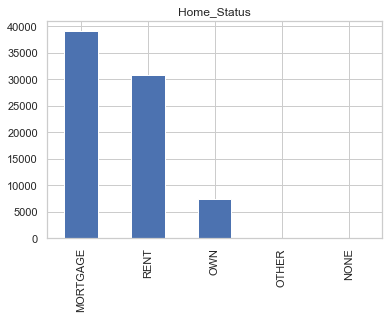

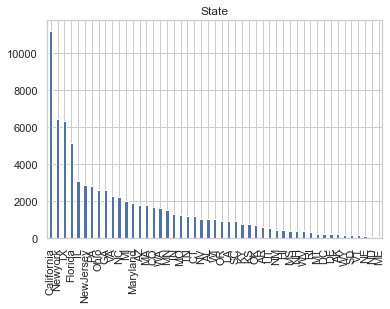

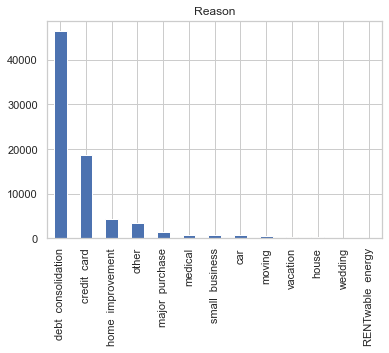

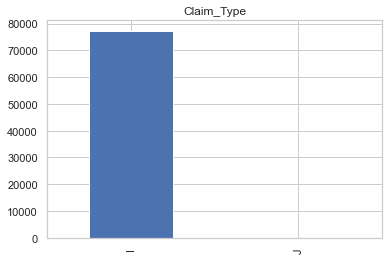

In [464]:
#fazer histograma das categoricas e value_counts (para ver se há categorias de pouca relevancia)
for i in catord.columns:
    plt.figure()
    print(cat[i].value_counts())
    catord[i].value_counts().plot(kind='bar',title=i)

### Avaliar correlações entre variáveis

In [518]:
#ver correlações
#falta acrescentar label
#crio vector com as features numericas continuas+discretas -> só faço corr com estas e label
display(vnumcont)
display(vnumdisc)
vnum=vnumcont+vnumdisc
display(vnum)
vnumlabel=vnum+['Default']
#print(vnumlabel)
df[vnumlabel].corr()
#mas confirmar, que posso fazer .corr() com binárias

['Asst_Reg',
 'Experience',
 'Yearly_Income',
 'Lend_Amount',
 'Interest_Charged',
 'Usage_Rate',
 'Present_Balance',
 'Due_Fee',
 'Unpaid_Amount']

['Unpaid_2_years', 'Already_Defaulted', 'Account_Open', 'Duration']

['Asst_Reg',
 'Experience',
 'Yearly_Income',
 'Lend_Amount',
 'Interest_Charged',
 'Usage_Rate',
 'Present_Balance',
 'Due_Fee',
 'Unpaid_Amount',
 'Unpaid_2_years',
 'Already_Defaulted',
 'Account_Open',
 'Duration']

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,Due_Fee,Unpaid_Amount,Unpaid_2_years,Already_Defaulted,Account_Open,Duration,Default
Asst_Reg,1.000000,-0.011723,0.035239,0.037186,-0.002571,-0.074240,0.011439,-0.064270,0.032632,0.035024,0.009119,0.055357,0.060966,-0.413878
Experience,-0.011723,1.000000,0.065124,0.092587,-0.001331,0.035039,0.099956,-0.005956,0.086779,0.015887,0.006864,0.030261,0.057528,0.002072
Yearly_Income,0.035239,0.065124,1.000000,0.377743,0.000422,0.046129,0.480897,0.010549,0.346428,0.047839,0.015697,0.146856,0.060152,-0.002147
Lend_Amount,0.037186,0.092587,0.377743,1.000000,-0.002254,0.114093,0.322504,0.036823,0.343429,-0.013663,0.000499,0.179493,0.408658,-0.059757
Interest_Charged,-0.002571,-0.001331,0.000422,-0.002254,1.000000,-0.001309,-0.002172,-0.001261,0.003999,0.000443,-0.001045,0.000167,0.000910,0.005430
Usage_Rate,-0.074240,0.035039,0.046129,0.114093,-0.001309,1.000000,0.080116,0.024741,0.219969,-0.016255,-0.027518,-0.159320,0.082862,-0.030807
Present_Balance,0.011439,0.099956,0.480897,0.322504,-0.002172,0.080116,1.000000,0.008945,0.431912,0.062572,0.020049,0.243721,0.107377,0.012020
Due_Fee,-0.064270,-0.005956,0.010549,0.036823,-0.001261,0.024741,0.008945,1.000000,-0.004922,0.022799,0.009956,-0.003249,0.012196,-0.016577
Unpaid_Amount,0.032632,0.086779,0.346428,0.343429,0.003999,0.219969,0.431912,-0.004922,1.000000,-0.035108,0.002057,0.220226,0.090940,-0.036908
Unpaid_2_years,0.035024,0.015887,0.047839,-0.013663,0.000443,-0.016255,0.062572,0.022799,-0.035108,1.000000,0.139529,0.045653,-0.006936,-0.030099


#### Gráfico de calor (heatmap)

Asst_Reg            -0.413878
Duration            -0.102061
Lend_Amount         -0.059757
Unpaid_Amount       -0.036908
Account_Open        -0.030829
Usage_Rate          -0.030807
Unpaid_2_years      -0.030099
Due_Fee             -0.016577
Already_Defaulted   -0.007956
Yearly_Income       -0.002147
Experience           0.002072
Interest_Charged     0.005430
Present_Balance      0.012020
Default              1.000000
Name: Default, dtype: float64

<AxesSubplot:>

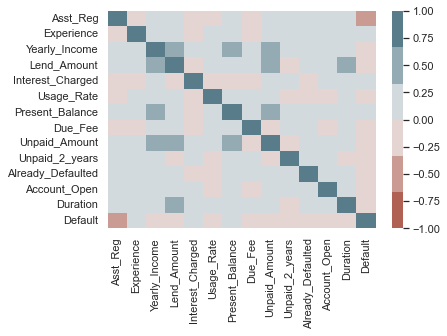

In [549]:
#mapa de calor entre a correlação das variáveis
corrTmp=df[vnumlabel].corr()
display((corrTmp.iloc[:,-1]).sort_values())
sns.heatmap(corrTmp,vmin=-1,vmax=1,center=0,cmap=sns.diverging_palette(20,220,50))

## Separação de dataset

In [467]:
#fazer split train/test, mantendo % de defaults=1 nos 2 subsets
train_set, test_set = train_test_split(df,test_size=0.2,random_state=1,stratify = df['Default'])
print(train_set['Default'].sum()/train_set['Default'].shape[0])
print(test_set['Default'].sum()/test_set['Default'].shape[0])
#ver como fazer para manter a % de defaults entre train e test!

0.18906300484652666
0.18906694236236754


## Pipelines

In [499]:
#pipeline para NUMPY ARRAY (AULAS)
d_ix=3
i_ix=2

class NewAttributes(BaseEstimator,TransformerMixin):
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        debt_to_income=X[:,d_ix]/X[:,i_ix]

        return np.c_[X,debt_to_income]
    
    @staticmethod
    def builDataframe(npArray, columnsTmp, newColumn):
        #Create array with more one value in column
        columnsTmp.append(newColumn)
        
        return pd.DataFrame(npArray, columns = columnsTmp)


In [578]:
#PIPELINE
vnumcont= vnumcont + ["GGGrade"]
numcont = df[vnumcont]
num=df[vnum]
vcat=['Home_Status','State','Reason','Claim_Type']
cat=df[vcat]
instances=df[vnum+vcat]

#Call Class
new_attr=NewAttributes()
extravar=new_attr.fit_transform(numcont.values)

#Convert arraynp to dataFrame
extravar_df = new_attr.builDataframe(extravar,numcont.columns.tolist(),'Debt_To_Income') 
extravar_df


,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,Due_Fee,Unpaid_Amount,GGGrade,Debt_To_Income
0,421802.0,10.0,633600.00,42023.25,15.39,88.924,607161.90,0.0,31216.05,2.0,0.066325
1,3964312.0,7.0,85483.20,38133.00,9.94,102.856,269234.06,0.0,11660.49,4.0,0.446088
2,4247560.0,1.0,79200.00,17100.00,22.35,60.372,22476.53,0.0,5637.87,3.0,0.215909
3,197179.0,1.0,61600.00,5130.00,10.36,116.272,15242.09,0.0,15607.17,3.0,0.083279
4,4646684.0,2.0,68053.92,19665.00,13.68,127.280,65433.94,0.0,27472.86,5.0,0.288962
...,...,...,...,...,...,...,...,...,...,...,...
77371,5409793.0,1.0,246400.00,20520.00,12.62,87.720,350087.11,0.0,10383.12,3.0,0.083279
77372,4535984.0,10.0,75680.00,10260.00,8.35,51.084,15100.14,0.0,10012.05,2.0,0.135571
77373,2624710.0,3.0,90423.52,27360.00,24.18,129.172,102811.88,0.0,24921.54,4.0,0.302576
77374,5966919.0,10.0,91520.00,8550.00,11.03,83.420,14584.11,0.0,14517.90,2.0,0.093422


In [506]:
pipeline_num=Pipeline([
    #('imputer',SimpleImputer(strategy='median')),
    ('std_scale',StandardScaler()),
    ('attr_add',NewAttributes())
])

#Run Pipeline
alltransfnum=pipeline_num.fit_transform(num)
display(alltransfnum.shape)

#Convert arraynp to dataFrame
extravar_df = new_attr.builDataframe(alltransfnum,num.columns.tolist(),'Debt_To_Income') 
extravar_df


(77376, 14)

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,Due_Fee,Unpaid_Amount,Unpaid_2_years,Already_Defaulted,Account_Open,Duration,Debt_To_Income
0,-1.476556,1.089708,5.009581,1.114403,-0.230024,-0.161681,1.452100,-0.089275,0.044810,-0.379265,-0.067419,0.783823,-0.675924,0.222454
1,0.070997,0.241827,-0.497416,0.845063,-1.341064,0.181387,0.128672,-0.089275,-0.475622,-0.379265,-0.067419,0.412170,1.479456,-1.698906
2,0.194734,-1.453935,-0.560544,-0.611149,1.188846,-0.864759,-0.837706,-0.089275,-0.635902,-0.379265,-0.067419,-1.074441,1.479456,1.090278
3,-1.574683,-1.453935,-0.737373,-1.439887,-1.255442,0.511749,-0.866038,-0.089275,-0.370589,-0.379265,-0.067419,-0.702788,-0.675924,1.952725
4,0.369092,-1.171308,-0.672530,-0.433562,-0.578625,0.782815,-0.669471,-0.089275,-0.054807,-0.379265,-0.067419,-0.516962,1.479456,0.644673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77371,0.702458,-1.453935,1.119335,-0.374366,-0.794718,-0.191329,0.445317,-0.089275,-0.509616,-0.379265,-0.067419,0.597997,-0.675924,-0.334454
77372,0.320733,1.089708,-0.595910,-1.084713,-1.665202,-1.093471,-0.866594,-0.089275,-0.519492,-0.379265,-0.067419,-0.145309,-0.675924,1.820265
77373,-0.514211,-0.888681,-0.447780,0.099198,1.561911,0.829404,-0.523088,-0.089275,-0.122706,-0.379265,-0.067419,1.898782,1.479456,-0.221534
77374,0.945840,1.089708,-0.436763,-1.203104,-1.118856,-0.297214,-0.868615,-0.089275,-0.399577,-0.379265,-0.067419,-0.888615,-0.675924,2.754592


In [316]:
attr_num=num.columns
attr_cat=cat.columns

global_pipeline=ColumnTransformer([
    ('num',pipeline_num,attr_num),
    ('cat',OneHotEncoder(),attr_cat)
])

preprocessed=global_pipeline.fit_transform(instances)
display(preprocessed.shape)
display(preprocessed)

(77376, 83)

<77376x83 sparse matrix of type '<class 'numpy.float64'>'
	with 1392768 stored elements in Compressed Sparse Row format>